<a href="https://colab.research.google.com/github/swetzel1/introduction_to_ml/blob/main/project/final_project_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physical Activity Monitoring


In [1]:
#load libraries

import numpy as np
import pandas as pd
import seaborn as sns

from pandas.plotting import scatter_matrix

from matplotlib import pyplot as plt

from imblearn.under_sampling  import RandomUnderSampler

from joblib import dump, load

from sklearn.model_selection  import train_test_split
from sklearn                  import metrics
from sklearn.decomposition    import PCA
from sklearn.metrics          import confusion_matrix

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data

In [3]:
activity_id_dict = {0: 'transient',
                    1: 'lying',
                    2: 'sitting',
                    3: 'standing',
                    4: 'walking',
                    5: 'running',
                    6: 'cycling',
                    7: 'Nordic_walking',
                    9: 'watching_TV',
                    10: 'computer_work',
                    11: 'car driving',
                    12: 'ascending_stairs',
                    13: 'descending_stairs',
                    16: 'vacuum_cleaning',
                    17: 'ironing',
                    18: 'folding_laundry',
                    19: 'house_cleaning',
                    20: 'playing_soccer',
                    24: 'rope_jumping' }



In [65]:
#load preprocessed data
data_path = '/content/drive/My Drive/final_project/dataset/preprocessed.csv'

raw_data = pd.DataFrame(pd.read_csv(data_path))

In [ ]:
data = raw_data

In [67]:
data.head()
data.shape

(1975200, 32)

In [68]:
#map activity id

activity_id_mapping= {1 :0,
                      2 :1,
                      3 :2,
                      4 :3,
                      5 :4,
                      6 :5,
                      7 :6,
                     12 :7,
                     16 :8,
                     13 :9,
                     17 :10,
                     24 :11 }

inv_activity_id_mapping = {v: k for k, v in activity_id_mapping.items()} #prepare reverse mapping for conf matrix


data['activity_id'] = data['activity_id'].map(activity_id_mapping)

In [44]:
#reduce dataset size, to test
'''
downsample_dict    = {1 :2000,
                      2 :2000,
                      3 :2000,
                      4 :2000,
                      5 :2000,
                      6 :2000,
                      7 :2000,
                     12 :2000,
                     16 :2000,
                     13 :2000,
                     17 :2000,
                     24 :2000 }


downsample_dict    = {0 :2000,
                      1 :2000,
                      2 :2000,
                      3 :2000,
                      4 :2000,
                      5 :2000,
                      6 :2000,
                      7 :2000,
                      8 :2000,
                      9 :2000,
                     10 :2000,
                     11 :2000}



## found it
col = data.columns
x_cols = col[:-1] #<<<---


'''

In [69]:
data.head()

,heartrate,hand_temperature,hand_Acc16_1,hand_Acc16_2,hand_Acc16_3,hand_Gyro1,hand_Gyro2,hand_Gyro3,hand_Magne1,hand_Magne2,...,ankle_Acc16_1,ankle_Acc16_2,ankle_Acc16_3,ankle_Gyro1,ankle_Gyro2,ankle_Gyro3,ankle_Magne1,ankle_Magne2,ankle_Magne3,activity_id
0,0.103448,0.921875,0.545767,0.558313,0.552159,0.513015,0.441780,0.498665,0.388548,0.668452,...,0.495432,0.471040,0.486238,0.579315,0.570432,0.459166,0.598851,0.711183,0.386694,0
1,0.117241,0.664062,0.586456,0.500008,0.565538,0.512737,0.441200,0.497938,0.499793,0.669392,...,0.504800,0.470115,0.503702,0.579566,0.570602,0.459349,0.572424,0.662129,0.358806,0
2,0.206897,0.453125,0.598482,0.508803,0.556485,0.512685,0.441971,0.497963,0.461029,0.657385,...,0.498404,0.469080,0.502309,0.579900,0.571544,0.460210,0.593281,0.675533,0.376911,0
3,0.234483,0.437500,0.522582,0.539130,0.565512,0.511076,0.444953,0.501005,0.375742,0.571248,...,0.528230,0.503089,0.495722,0.570374,0.569652,0.462040,0.491398,0.600808,0.641354,0
4,0.165517,0.546875,0.600440,0.509517,0.553068,0.512867,0.443044,0.498676,0.418593,0.722963,...,0.496763,0.478225,0.477100,0.579329,0.571042,0.458785,0.583292,0.786114,0.415781,0


In [70]:
#split x,y
col = data.columns
x_cols = col[:-1] #found it <-------

y_df = data['activity_id']
x_df = data[x_cols]

x_np =x_df.to_numpy()
y_np =y_df.to_numpy()


In [81]:
#PCA
k = 15 #optimal value to be found
pca = PCA(n_components=k)

x_pc = pca.fit_transform(x_np)

In [82]:
#to tensor

x = torch.tensor(x_pc, dtype=torch.float32) #pca or without
y = torch.tensor(y_np, dtype=torch.long)

In [83]:
#split train & val
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size = 0.8, test_size = 0.2, random_state = 100)

In [84]:
x_train.shape


torch.Size([1580160, 15])

In [85]:
## are the results so good, because the input feautes contained the grand truth???

# Neural Network

In [86]:
#pseudo model
'''
input_dim  = 31  # number of principal components
output_dim = 12

n_layer1 = 64

model = nn.Sequential(
            nn.Linear(input_dim, n_layer1), #layer 1
            nn.Tanh(),
            nn.Linear(n_layer1, output_dim),
            nn.LogSoftmax(dim=1))

'''

#proper model

input_dim  = 15  # number of pcas
output_dim = 12  # no. of activities

n_layer1 = 64
n_layer2 = 128
n_layer3 = 64

model = nn.Sequential(
            nn.Linear(input_dim, n_layer1), #layer 1
            nn.Tanh(),
            nn.Linear(n_layer1, n_layer2), # layer 2
            nn.Tanh(),
            nn.Linear(n_layer2, n_layer3), # layer 3
            nn.Tanh(),
            nn.Linear(n_layer3, output_dim),
            nn.LogSoftmax(dim=1))


In [87]:
#Data Loader
batch_size   = 500
train_loader = DataLoader(list(zip(x_train, y_train)), shuffle=True, batch_size=batch_size)

In [88]:
learning_rate = 0.01
n_epochs = 20

optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()


for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:

        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 1.545659
Epoch: 1, Loss: 1.309854
Epoch: 2, Loss: 1.014787
Epoch: 3, Loss: 0.945313
Epoch: 4, Loss: 0.831916
Epoch: 5, Loss: 0.750836
Epoch: 6, Loss: 0.670015
Epoch: 7, Loss: 0.678463
Epoch: 8, Loss: 0.657850
Epoch: 9, Loss: 0.635436
Epoch: 10, Loss: 0.539329
Epoch: 11, Loss: 0.543030
Epoch: 12, Loss: 0.567463
Epoch: 13, Loss: 0.317107
Epoch: 14, Loss: 0.491581
Epoch: 15, Loss: 0.418814
Epoch: 16, Loss: 0.344037
Epoch: 17, Loss: 0.348343
Epoch: 18, Loss: 0.427282
Epoch: 19, Loss: 0.382053


In [89]:
batch_size   = 500
val_loader = DataLoader(list(zip(x_val, y_val)), shuffle=True, batch_size=batch_size)


nb_classes = 12
cnf_matrix = torch.zeros(nb_classes, nb_classes)

with torch.no_grad():
    for x_batch, y_batch in val_loader:


        y_pred = model(x_batch)
        _, preds = torch.max(y_pred, 1)

        for t, p in zip(y_batch.view(-1), preds.view(-1)):
                cnf_matrix[t.long(), p.long()] += 1


In [90]:
'''
#for debugging reasons

#batch_size   = 1
#val_loader = DataLoader(list(zip(x_val, y_val)), shuffle=True, batch_size=batch_size)


with torch.no_grad():
    for x_batch, y_batch in val_loader:

        #print(x_batch)
        print('ground thruth:', y_batch)


        y_pred = model(x_batch)

        print(y_pred)


        _, preds = torch.max(y_pred, 1)

        print('predicted:', preds)

        break
'''

"\n#for debugging reasons\n\n#batch_size   = 1\n#val_loader = DataLoader(list(zip(x_val, y_val)), shuffle=True, batch_size=batch_size)\n\n\nwith torch.no_grad():\n    for x_batch, y_batch in val_loader:\n\n        #print(x_batch)\n        print('ground thruth:', y_batch)\n\n\n        y_pred = model(x_batch)\n\n        print(y_pred)\n\n\n        _, preds = torch.max(y_pred, 1)\n\n        print('predicted:', preds)\n\n        break\n"

Text(0.5, 47.5815972222222, 'Predicted label')

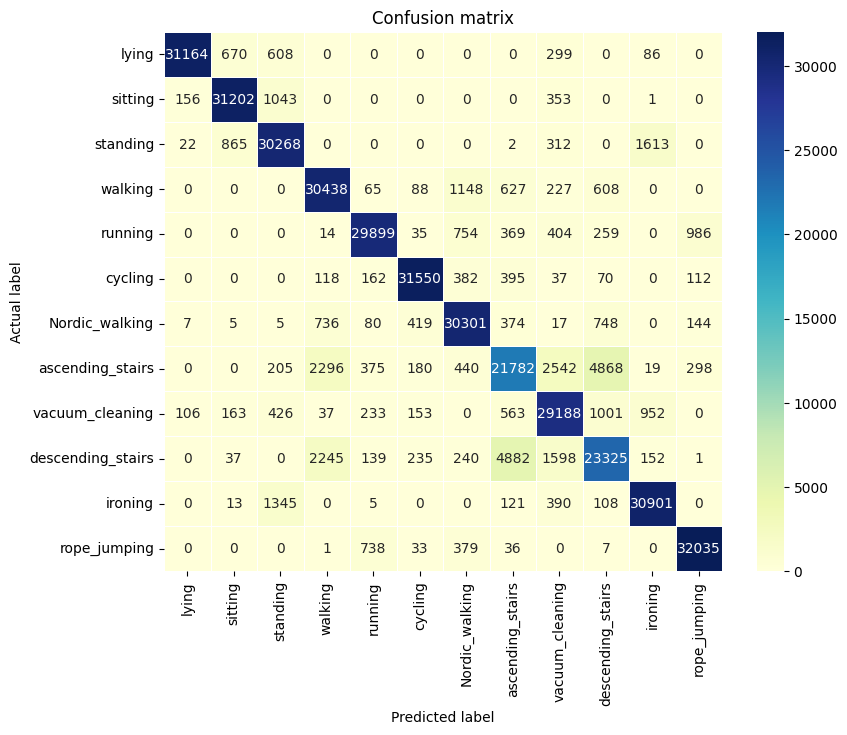

In [98]:
# create heatmap
class_labels = list(range(0,12,1))
class_labels = [inv_activity_id_mapping.get(x) for x in class_labels]
class_labels = [activity_id_dict.get(x) for x in class_labels]

fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g',linewidths=0.5, xticklabels=class_labels, yticklabels=class_labels, ax=ax)

plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [96]:
cnf_matrix = pd.DataFrame(cnf_matrix)

In [99]:
#Performance

recall = np.diag(cnf_matrix) / np.sum(cnf_matrix, axis = 1)
precision = np.diag(cnf_matrix) / np.sum(cnf_matrix, axis = 0)
f1_score = (2*recall*precision) / (recall+precision)

d = {'activity':class_labels, 'precision':precision, 'recall':recall, 'f1-score':f1_score}
performance = pd.DataFrame(data = d)
performance

,activity,precision,recall,f1-score
0,lying,0.990749,0.949340,0.969603
1,sitting,0.946806,0.952587,0.949688
2,standing,0.892861,0.914939,0.903765
3,walking,0.848210,0.916780,0.881163
4,running,0.943305,0.913784,0.928310
5,cycling,0.965038,0.961128,0.963079
6,Nordic_walking,0.900636,0.922798,0.911582
7,ascending_stairs,0.747213,0.659961,0.700882
8,vacuum_cleaning,0.825289,0.889282,0.856091
9,descending_stairs,0.752565,0.709959,0.730642


In [100]:
precision_mean = np.sum(performance['precision']) / performance.shape[0]
recall_mean = np.sum(performance['recall']) / performance.shape[0]
f1_mean = np.sum(performance['f1-score']) / performance.shape[0]

#print("Accuracy:   %.4f" % (correct_val / total_val))
print("Precsision: %.4f" % precision_mean)
print("Recall:     %.4f" % recall_mean)
print("F1-score:   %.4f" % f1_mean)


Precsision: 0.8903
Recall:     0.8912
F1-score:   0.8901


In [101]:
#!!! careful, dont override other models !!!

model_path = '/content/drive/My Drive/final_project/models/'


#torch.save(model.state_dict(), model_path + 'nn_64_128_64_lr0_01_20e.pt')



#Load model

#model.load_state_dict(torch.load(file_path+'p2b_0.001.pt'))